# Exploration


In [1]:
# Importing Necessary packages 
import pandas as pd
import numpy as np
from Utils.Metrics import Metrics
from Utils.ModelStats import ModelStats
from Utils.Preprocessor import TrainingPreprocessor

In [82]:
exchange = 'Binance'

# Input cleaned data

In [102]:
# Importing Exchange Data
book = pd.read_csv(f"Data/{exchange}/book/{exchange}_l2_cleaned1.csv",error_bad_lines=False, engine="python")


In [104]:
trades = pd.read_csv(f"Data/{exchange}/trade/{exchange}_trades_cleaned1.csv")

In [105]:
book.shape

(529579, 10)

In [106]:
trades.shape

(328709, 5)

In [107]:
book.head()

,Unnamed: 0,receipt_timestamp,bid,ask,best_bid_price,best_ask_price,best_bid_volume,best_ask_volume,bid_total_depth,ask_total_depth
0,17013,2021-09-17 09:01:59.413,"{'48120.39':'0.00097','48120.35':'0.00277','48...","{'48120.4':'2.90422','48120.88':'0.00832','481...",48120.39,48120.4,0.00097,2.90422,2.82281,9.19430
1,17014,2021-09-17 09:01:59.675,"{'48120.39':'0.00097','48120.35':'0.00277','48...","{'48120.4':'2.87857','48120.88':'0.00832','481...",48120.39,48120.4,0.00097,2.87857,2.42144,9.16865
2,17015,2021-09-17 09:01:59.681,"{'48120.39':'0.02557','48120.35':'0.00277','48...","{'48120.4':'3.47222','48120.88':'0.00832','481...",48120.39,48120.4,0.02557,3.47222,2.58131,9.75230
3,17016,2021-09-17 09:01:59.714,"{'48120.39':'0.00097','48120.35':'0.00277','48...","{'48120.4':'3.71222','48120.88':'0.00832','481...",48120.39,48120.4,0.00097,3.71222,2.31647,10.41420
4,17017,2021-09-17 09:01:59.812,"{'48120.39':'0.01097','48119.91':'0.00832','48...","{'48120.4':'3.69419','48120.88':'0.00832','481...",48120.39,48120.4,0.01097,3.69419,2.32934,10.39617


In [108]:
trades.head()

,Unnamed: 0,receipt_timestamp,side,amount,price
0,21,2021-09-17 09:01:59.544,buy,0.02565,48120.40
1,22,2021-09-17 09:01:59.680,buy,0.01062,48120.40
2,23,2021-09-17 09:01:59.730,buy,0.01803,48120.40
3,24,2021-09-17 09:01:59.938,sell,0.00208,48120.39
4,25,2021-09-17 09:02:01.558,buy,0.01514,48120.40


# Basic Statistics

In [109]:
book.describe()

,Unnamed: 0,best_bid_price,best_ask_price,best_bid_volume,best_ask_volume,bid_total_depth,ask_total_depth
count,529579.000000,529579.000000,529579.000000,529579.000000,529579.000000,529579.000000,529579.000000
mean,429099.785734,47728.596313,47728.711522,0.737894,0.855357,4.079868,4.166581
std,247782.072772,539.729857,539.717084,1.178855,1.513899,2.986384,3.521724
min,0.000000,46751.010000,46754.030000,0.000010,0.000010,0.033070,0.039350
25%,213143.500000,47327.030000,47327.160000,0.057270,0.066040,2.334740,2.394755
50%,428823.000000,47544.060000,47544.340000,0.333740,0.392310,3.781140,3.725790
75%,646039.000000,48087.510000,48087.520000,0.997010,1.166920,5.202160,5.353345
max,850909.000000,48827.000000,48831.510000,30.593170,97.970690,59.231590,104.866860


In [110]:
trades.describe()

,Unnamed: 0,amount,price
count,328709.000000,328709.000000,328709.000000
mean,164354.000000,0.032666,47724.077628
std,94890.259155,0.099628,571.043780
min,0.000000,0.000010,46751.000000
25%,82177.000000,0.001700,47307.650000
50%,164354.000000,0.007920,47528.930000
75%,246531.000000,0.025690,48241.860000
max,328708.000000,5.751920,48831.510000


# OFI/ TFI

In [111]:
def ofi_tfi(quotes, trades, dt):
    qdf = quotes.copy().reset_index()
    tdf = trades.copy().reset_index()
    
    qdf['timestamp'] = pd.to_datetime(qdf['receipt_timestamp'])
    tdf['timestamp'] = pd.to_datetime(tdf['receipt_timestamp'])
                                      
    # TFI
    tdf['sgn_size'] = np.where(tdf['side'] == 'buy', tdf['amount'], -tdf['amount'])
    
    # Mid-price change 
    qdf['Mid-Price'] = (qdf['best_bid_price'] + qdf['best_ask_price'])/2
    qdf['Mid-Price Percent Change'] = np.log(qdf['Mid-Price']) - np.log(qdf['Mid-Price'].shift(1))
    qdf['Mid-Price Change'] = ((qdf['best_bid_price'] + qdf['best_ask_price'])/2).diff().div(0.1)
    qdf['Spread'] = qdf['best_ask_price'] - qdf['best_bid_price']
    
    # Previous bid and ask prices 
    qdf['prev_bidprice'] = qdf['best_bid_price'].shift()
    qdf['prev_bidsize'] = qdf['best_bid_volume'].shift()
    qdf['prev_askprice'] = qdf['best_ask_price'].shift()
    qdf['prev_asksize'] = qdf['best_ask_volume'].shift()

    qdf.dropna(inplace=True)
    
    # Creation of Identity Functions for OFI
    bid_geq = qdf['best_bid_price'] >= qdf['prev_bidprice']
    bid_leq = qdf['best_bid_price'] <= qdf['prev_bidprice']
    ask_geq = qdf['best_ask_price'] >= qdf['prev_askprice']
    ask_leq = qdf['best_ask_price'] <= qdf['prev_askprice']
    
    # Creation of OFI Variable
    qdf['OFI'] = 0
    qdf['OFI'].loc[bid_geq] += qdf['best_bid_volume'].loc[bid_geq]
    qdf['OFI'].loc[bid_leq] -= qdf['prev_bidsize'].loc[bid_leq]
    qdf['OFI'].loc[ask_geq] += qdf['prev_asksize'][ask_geq]
    qdf['OFI'].loc[ask_leq] -= qdf['best_ask_volume'][ask_leq]
    
    # Creation of ODI Variable
    qdf['ODI'] = 0
    qdf['ODI'].loc[bid_leq] += 1
    qdf['ODI'].loc[ask_geq] -= 1
    
    # Depth imbalance 
    qdf['Depth_diff'] = qdf['ask_total_depth'] - qdf['bid_total_depth']
    qdf = qdf.set_index('timestamp')
    tdf = tdf.set_index('timestamp')
    
    qdf = qdf[['Mid-Price Percent Change','OFI','ODI','Spread','Depth_diff']].resample(dt).sum().dropna()
    tf = tdf['sgn_size'].resample(dt).sum().fillna(0.0)
    qdf.name = 'OFI_df_' + str(dt)
                                      
    ofi_tfi_df = pd.merge(qdf, tf, left_index=True, right_index=True)
    ofi_tfi_df['OFI Difference'] = ofi_tfi_df['OFI'] - ofi_tfi_df['OFI'].shift(1)
    ofi_tfi_df['ODI Difference'] = ofi_tfi_df['ODI'] - ofi_tfi_df['ODI'].shift(1)
    ofi_tfi_df['TFI Difference'] = ofi_tfi_df['sgn_size'] - ofi_tfi_df['sgn_size'].shift(1)
    ofi_tfi_df['change_t1'] = ofi_tfi_df['Mid-Price Percent Change'].shift(1)
    return ofi_tfi_df.dropna()


In [112]:
time_differences = ['1S', '10S','30S', '1T', '5T', '10T']

dt = '1T'

book_processed = ofi_tfi(book, trades, dt)

In [113]:
book_processed.shape

(1668, 10)

In [114]:
book_processed.head(10)

,Mid-Price Percent Change,OFI,ODI,Spread,Depth_diff,sgn_size,OFI Difference,ODI Difference,TFI Difference,change_t1
timestamp,,,,,,,,,,
2021-09-17 09:02:00,-0.000140,-25.09658,-1,11.58,142.68002,-1.04912,-24.31938,-1.0,-1.10134,0.000000
2021-09-17 09:03:00,0.000066,-30.41103,3,28.85,180.64013,-0.46177,-5.31445,4.0,0.58735,-0.000140
2021-09-17 09:04:00,-0.000087,-43.05467,7,35.39,535.92519,3.84663,-12.64364,4.0,4.30840,0.000066
2021-09-17 09:05:00,-0.000288,-45.95809,8,13.31,648.58971,1.00448,-2.90342,1.0,-2.84215,-0.000087
2021-09-17 09:06:00,-0.000185,-52.16133,11,6.13,-0.52665,1.23414,-6.20324,3.0,0.22966,-0.000288
2021-09-17 09:07:00,-0.000204,-27.67458,3,6.34,56.87134,0.18459,24.48675,-8.0,-1.04955,-0.000185
2021-09-17 09:08:00,0.000017,-30.41285,5,3.60,936.18291,0.64169,-2.73827,2.0,0.45710,-0.000204
2021-09-17 09:09:00,-0.000362,-28.97938,5,11.60,612.90667,5.26131,1.43347,0.0,4.61962,0.000017
2021-09-17 09:10:00,0.000678,64.28085,-20,5.81,-414.35080,12.33718,93.26023,-25.0,7.07587,-0.000362


# Correlations

In [115]:
metrics_generator = Metrics()

In [116]:
book_processed.corr()

,Mid-Price Percent Change,OFI,ODI,Spread,Depth_diff,sgn_size,OFI Difference,ODI Difference,TFI Difference,change_t1
Mid-Price Percent Change,1.000000,0.720453,-0.814462,0.042239,-0.292699,0.413767,0.608141,-0.652056,0.331619,-0.095616
OFI,0.720453,1.000000,-0.818401,0.019806,-0.282414,0.342897,0.638426,-0.534928,0.230891,0.046205
ODI,-0.814462,-0.818401,1.000000,-0.014820,0.325847,-0.299410,-0.572538,0.672392,-0.218408,-0.041774
Spread,0.042239,0.019806,-0.014820,1.000000,0.041104,0.135517,0.023094,-0.043318,0.062116,-0.043722
Depth_diff,-0.292699,-0.282414,0.325847,0.041104,1.000000,0.235420,-0.109079,0.132583,0.174133,-0.145121
sgn_size,0.413767,0.342897,-0.299410,0.135517,0.235420,1.000000,0.259711,-0.209444,0.692635,0.008558
OFI Difference,0.608141,0.638426,-0.572538,0.023094,-0.109079,0.259711,1.000000,-0.844691,0.368310,-0.528056
ODI Difference,-0.652056,-0.534928,0.672392,-0.043318,0.132583,-0.209444,-0.844691,1.000000,-0.313605,0.574582
TFI Difference,0.331619,0.230891,-0.218408,0.062116,0.174133,0.692635,0.368310,-0.313605,1.000000,-0.292513
change_t1,-0.095616,0.046205,-0.041774,-0.043722,-0.145121,0.008558,-0.528056,0.574582,-0.292513,1.000000


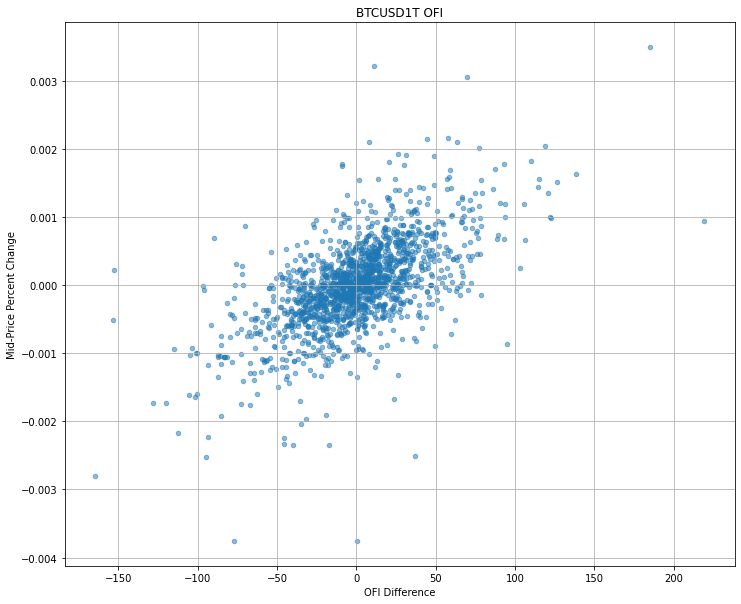

In [118]:
metrics_generator.plot_correlation(book_processed, 'OFI Difference', 'Mid-Price Percent Change', coin='BTCUSD', dt=dt)

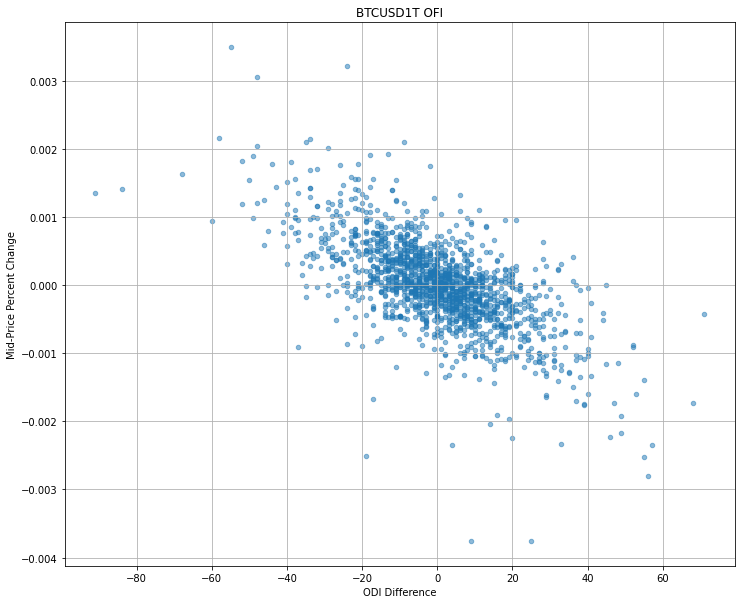

In [119]:
metrics_generator.plot_correlation(book_processed, 'ODI Difference', 'Mid-Price Percent Change', coin='BTCUSD', dt=dt)

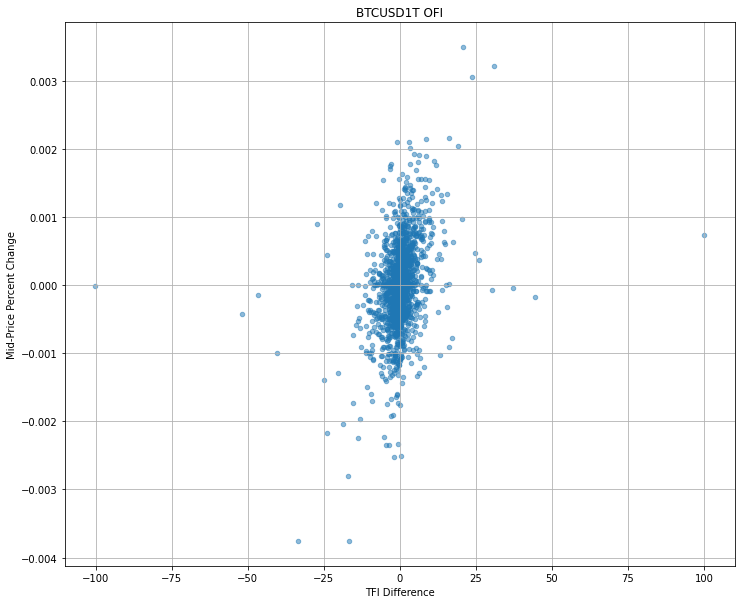

In [120]:
metrics_generator.plot_correlation(book_processed, 'TFI Difference', 'Mid-Price Percent Change', coin='BTCUSD', dt=dt)

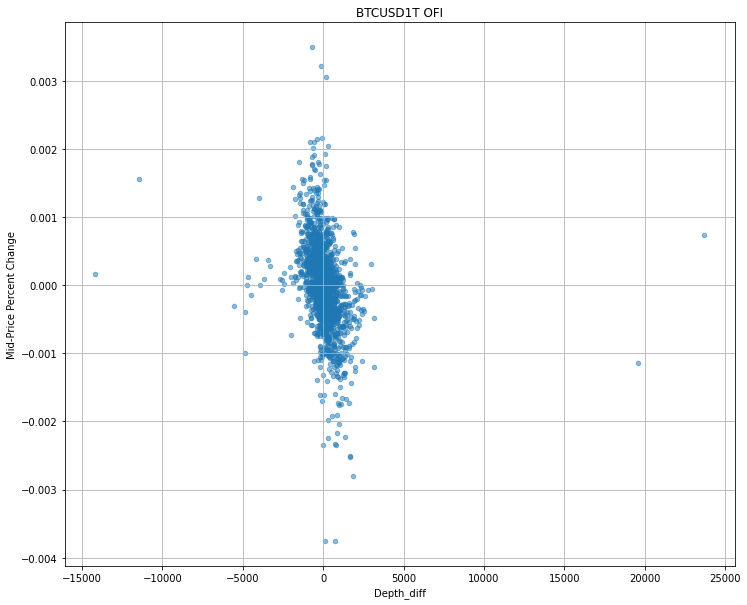

In [121]:
metrics_generator.plot_correlation(book_processed, 'Depth_diff', 'Mid-Price Percent Change', coin='BTCUSD', dt=dt)

# General Regressions

In [122]:
metrics_generator.plot_ols_summary(book_processed, ['OFI Difference'], 'Mid-Price Percent Change')

                      Results: Ordinary least squares
Model:              OLS                      Adj. R-squared:     0.369      
Dependent Variable: Mid-Price Percent Change AIC:                -20572.3628
Date:               2021-10-01 09:13         BIC:                -20561.5240
No. Observations:   1668                     Log-Likelihood:     10288.     
Df Model:           1                        F-statistic:        977.8      
Df Residuals:       1666                     Prob (F-statistic): 2.83e-169  
R-squared:          0.370                    Scale:              2.5740e-07 
-------------------------------------------------------------------------------
                   Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
-------------------------------------------------------------------------------
const              0.0000      0.0000     0.4812    0.6304    -0.0000    0.0000
OFI Difference     0.0000      0.0000    31.2690    0.0000     0.0000    0.0000
-------

/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [123]:
metrics_generator.plot_ols_summary(book_processed, ['ODI Difference'], 'Mid-Price Percent Change')

                      Results: Ordinary least squares
Model:              OLS                      Adj. R-squared:     0.425      
Dependent Variable: Mid-Price Percent Change AIC:                -20725.6829
Date:               2021-10-01 09:13         BIC:                -20714.8442
No. Observations:   1668                     Log-Likelihood:     10365.     
Df Model:           1                        F-statistic:        1232.      
Df Residuals:       1666                     Prob (F-statistic): 1.47e-202  
R-squared:          0.425                    Scale:              2.3480e-07 
------------------------------------------------------------------------------
                     Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
------------------------------------------------------------------------------
const                0.0000     0.0000     0.5043   0.6141   -0.0000    0.0000
ODI Difference      -0.0000     0.0000   -35.1039   0.0000   -0.0000   -0.0000
------------

/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [124]:
metrics_generator.plot_ols_summary(book_processed, ['TFI Difference'], 'Mid-Price Percent Change')

                      Results: Ordinary least squares
Model:              OLS                      Adj. R-squared:     0.109      
Dependent Variable: Mid-Price Percent Change AIC:                -19996.4479
Date:               2021-10-01 09:13         BIC:                -19985.6091
No. Observations:   1668                     Log-Likelihood:     10000.     
Df Model:           1                        F-statistic:        205.8      
Df Residuals:       1666                     Prob (F-statistic): 4.19e-44   
R-squared:          0.110                    Scale:              3.6355e-07 
-------------------------------------------------------------------------------
                   Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
-------------------------------------------------------------------------------
const              0.0000      0.0000     0.4054    0.6853    -0.0000    0.0000
TFI Difference     0.0000      0.0000    14.3475    0.0000     0.0000    0.0000
-------

/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [125]:
metrics_generator.plot_ols_summary(book_processed, ['ODI Difference','OFI Difference'], 'Mid-Price Percent Change')

                      Results: Ordinary least squares
Model:              OLS                      Adj. R-squared:     0.436      
Dependent Variable: Mid-Price Percent Change AIC:                -20757.3387
Date:               2021-10-01 09:13         BIC:                -20741.0806
No. Observations:   1668                     Log-Likelihood:     10382.     
Df Model:           2                        F-statistic:        645.3      
Df Residuals:       1665                     Prob (F-statistic): 3.29e-208  
R-squared:          0.437                    Scale:              2.3025e-07 
------------------------------------------------------------------------------
                     Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
------------------------------------------------------------------------------
const                0.0000     0.0000     0.5091   0.6108   -0.0000    0.0000
ODI Difference      -0.0000     0.0000   -14.0536   0.0000   -0.0000   -0.0000
OFI Differen

/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [126]:
metrics_generator.plot_ols_summary(book_processed, ['ODI Difference','OFI Difference','TFI Difference'], 'Mid-Price Percent Change')

                      Results: Ordinary least squares
Model:              OLS                      Adj. R-squared:     0.449      
Dependent Variable: Mid-Price Percent Change AIC:                -20794.6001
Date:               2021-10-01 09:13         BIC:                -20772.9226
No. Observations:   1668                     Log-Likelihood:     10401.     
Df Model:           3                        F-statistic:        453.4      
Df Residuals:       1664                     Prob (F-statistic): 2.99e-215  
R-squared:          0.450                    Scale:              2.2502e-07 
------------------------------------------------------------------------------
                     Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
------------------------------------------------------------------------------
const                0.0000     0.0000     0.5150   0.6066   -0.0000    0.0000
ODI Difference      -0.0000     0.0000   -14.1839   0.0000   -0.0000   -0.0000
OFI Differen

/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Exploring 

ADF Statistic: -44.91248510428176
p-value: 0.0
Critial Values:
   1%, -3.43427885313169
   5%, -2.863275365507293
   10%, -2.5676938662645394
KPSS Statistic: 0.45025582173455664
p-value: 0.05549318028682904
num lags: 25
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


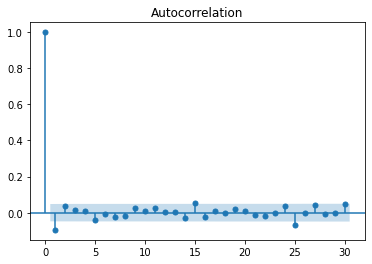

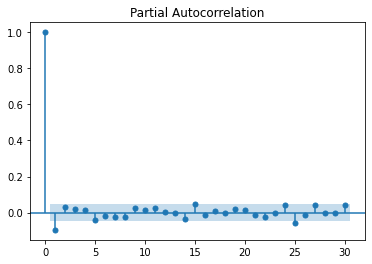

In [127]:
metrics_generator.adf(book_processed['Mid-Price Percent Change'].values)
metrics_generator.kpss_test(book_processed['Mid-Price Percent Change'].values)
metrics_generator.plot_acf_pacf(book_processed['Mid-Price Percent Change'].values)

ADF Statistic: -16.26625929756325
p-value: 3.524717993685861e-29
Critial Values:
   1%, -3.434283579780684
   5%, -2.863277451883613
   10%, -2.5676949772294817
KPSS Statistic: 0.08893006154087386
p-value: 0.1
num lags: 25
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


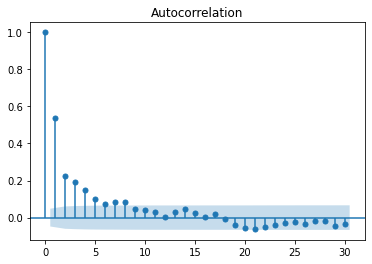

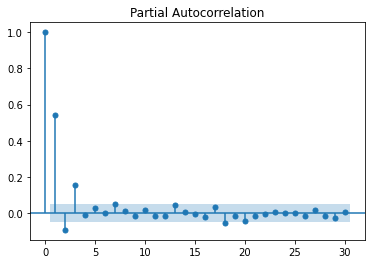

In [128]:
metrics_generator.adf(book_processed['Depth_diff'].values)
metrics_generator.kpss_test(book_processed['Depth_diff'].values)
metrics_generator.plot_acf_pacf(book_processed['Depth_diff'].values)

ADF Statistic: -12.167108731522363
p-value: 1.4488090397054866e-22
Critial Values:
   1%, -3.4343387651403106
   5%, -2.8633018108486343
   10%, -2.5677079480625067
KPSS Statistic: 0.007428015200277099
p-value: 0.1
num lags: 25
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


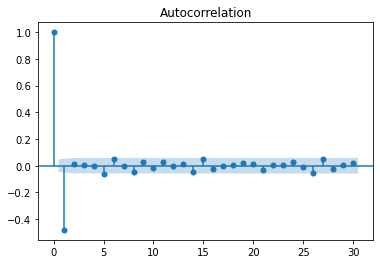

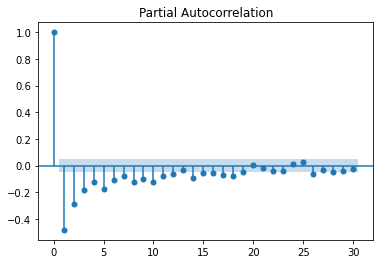

In [129]:
metrics_generator.adf(book_processed['OFI Difference'].values)
metrics_generator.kpss_test(book_processed['OFI Difference'].values)
metrics_generator.plot_acf_pacf(book_processed['OFI Difference'].values)

ADF Statistic: -13.560084777453657
p-value: 2.319117909790096e-25
Critial Values:
   1%, -3.4343387651403106
   5%, -2.8633018108486343
   10%, -2.5677079480625067
KPSS Statistic: 0.007699355551988311
p-value: 0.1
num lags: 25
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


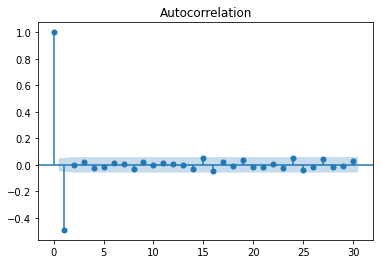

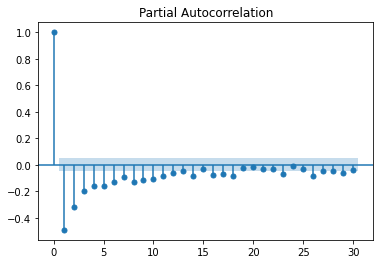

In [130]:
metrics_generator.adf(book_processed['ODI Difference'].values)
metrics_generator.kpss_test(book_processed['ODI Difference'].values)
metrics_generator.plot_acf_pacf(book_processed['ODI Difference'].values)

ADF Statistic: -13.599720699834634
p-value: 1.9637688017798001e-25
Critial Values:
   1%, -3.4343363335985666
   5%, -2.8633007375690576
   10%, -2.5677073765535114
KPSS Statistic: 0.007858718057253678
p-value: 0.1
num lags: 25
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/imperialhound/anaconda3/envs/cuda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


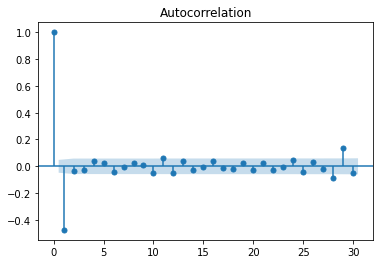

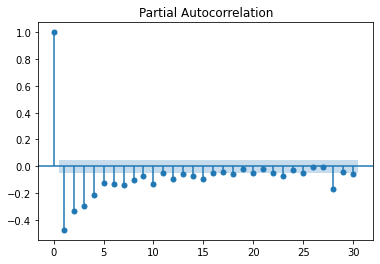

In [131]:
metrics_generator.adf(book_processed['TFI Difference'].values)
metrics_generator.kpss_test(book_processed['TFI Difference'].values)
metrics_generator.plot_acf_pacf(book_processed['TFI Difference'].values)

# Simple Predictions - Testing Theory

In [132]:
# Organize dataframe for training 
time_series_hidden = book_processed[['Mid-Price Percent Change', 'Depth_diff','OFI Difference','ODI Difference','TFI Difference','change_t1']]
time_series_no_hidden = book_processed[['Mid-Price Percent Change', 'Depth_diff','OFI Difference','TFI Difference','change_t1']]

In [150]:
model_statistics = ModelStats(random_walk=True, df=time_series_no_hidden, model='linear regression', target='change_t1')
rmse, r2, predictions_list, ytest_list = model_statistics.generate_model_statistics()

RMSE: 0.000635695443665342
R_Squared Score : 0.06682423949417342


In [151]:
model_statistics = ModelStats(random_walk=False, df=time_series_no_hidden, model='linear regression', target='change_t1')
rmse, r2, predictions_list, ytest_list = model_statistics.generate_model_statistics()

RMSE: 0.0005274428078853617
R_Squared Score : 0.5609416971091341


In [152]:
model_statistics = ModelStats(random_walk=False, df=time_series_hidden, model='linear regression', target='change_t1')
rmse, r2, predictions_list, ytest_list = model_statistics.generate_model_statistics()

RMSE: 0.00048277579532186063
R_Squared Score : 0.6525477933071284
